# Neural Networks III: Hyperparameter Tuning
### Implemented in Python with Keras

<i>Patrick White</i></br>
<i>Jan 04, 2025</i>

<img src="img/nn3.png" style="height: 450px; width:auto;">

# Outline

- NN Training Hyperparameters
- Import Libraries and Data
- Prepare Data
- Initial Settings
- Fit Function
- Number of layers and nodes
- Optimizer (SGD, Adam, etc.)
- Batch Size
- Learning Rate
- Momentum
- Weight Regularization
- Dropout
- Other Hyperparameters
    - Loss Function
    - Activation Function
    - Early Stopping
    - Batch Normalization
    - Weight Constraints
    - Activity Regularization 
    - Noise

# NN Training Hyperparameters

A number of determinations go into the training process for neural networks. These can be thought of as hyperparameters - not the actual weights and biases connecting nodes, but rather, additional factors which will play a role in arriving at those weights and biases. These include the list you see above in the outline.

Below, we will compare the performance at various settings for such hyperparameters, using the MNIST dataset from Keras.

# Import Libraries and Data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.regularizers import l1, l2

from sklearn.preprocessing import LabelBinarizer

from tqdm import tqdm

In [30]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

# Prepare Data

To apply a standard feedforward neural network, we must "flatten" the data to a list of 28x28=784 pixels.

In [31]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28 * 1))
X_test = X_test.reshape((X_test.shape[0], 28 * 28 * 1))

# scale
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [32]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [33]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [34]:
np.random.seed(123)

In [35]:
X_train.shape

(60000, 784)

# Initial Settings

We'll set some sensible defaults for things like learning rate, but then proceed to tune these parameters one or two at a time. We’ll also set a random seed for reproducibility.

In [36]:
np.random.seed(123)

# n_layers = TBD
# n_nodes = TBD

epochs = 40
batch_size = 30000
opt = Adam
lr = 0.01
momentum = 1
reg_type = l2
reg = 0
dropout = 0
loss_fx = 'categorical_crossentropy'
activation_fx = 'relu'

# Fit Function

The below function is what will be called upon for each hyperparameter value we want to search. Note that it's pretty basic - for example, each layer is set to have the same number of nodes. This is to simplify for the sake of demonstration, but you may want to refine such aspects.

In [37]:
def fit_model():

    # determine input and output shapes
    n_input, n_classes = X_train.shape[1], y_test.shape[1]

    # instantiate model
    model = Sequential()
    model.add(Dense(n_nodes,
                  input_dim=n_input,
                  activation=activation_fx))

    # create inner layers
    for l in range(0, n_layers):
      model.add(Dense(n_input,
                      activation=activation_fx,
                      kernel_regularizer=reg_type(reg)))

      # add dropout if specified
      if dropout != 0 and dropout != None:
          model.add(Dropout(dropout))

      # create output layer
      model.add(Dense(n_classes,
                    activation='softmax'))

      # compile model
      model.compile(loss=loss_fx,
                  optimizer=opt(learning_rate=lr,
                                ema_momentum=momentum),
                  metrics=['accuracy'])

      # train and capture performance by epoch
      history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        verbose=0,
                        batch_size=batch_size)

      # evaluate against test set
      _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return history, test_acc

# Number of Layers and Nodes

We'll start by searching for the right number of layers and nodes. I haven't spent time refining the values being searched, but one could iteratively run the search and then refine the parameters of their search. It makes sense to grid search the number of layers and nodes together, because the optimal number of nodes can be strongly dependent on the number of layers, and vice versa.

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 3/3 [07:53<00:00, 157.89s/it]


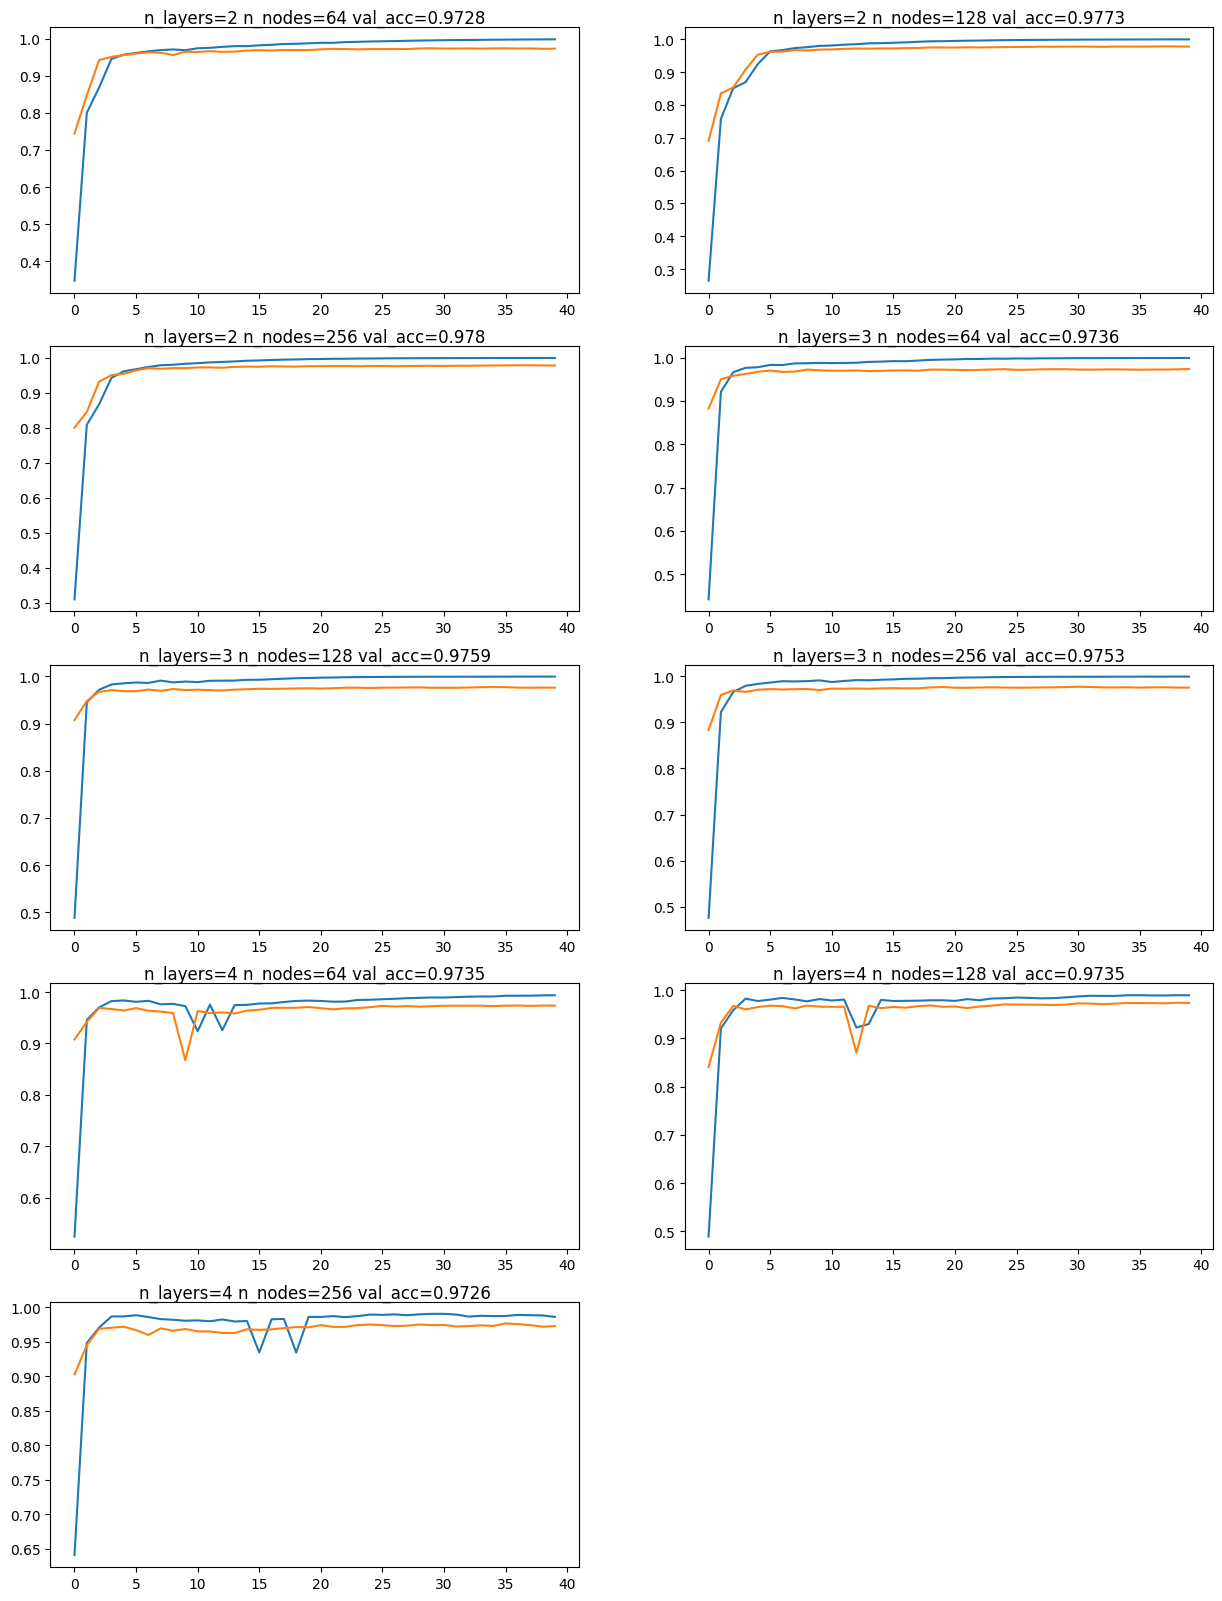

In [22]:
n_layers_lst = [2,3,4]
n_nodes_lst = [64,128,256]
counter = 0

plt.figure(figsize=(15,20))
for i in tqdm(range(len(n_layers_lst))):
    n_layers = n_layers_lst[i]

    for j in range(len(n_nodes_lst)):
        n_nodes = n_nodes_lst[j]
        history, test_acc = fit_model()
        counter = counter + 1
        plot_no = 520 + counter
        plt.subplot(plot_no)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.title('n_layers='+str(n_layers_lst[i])+' n_nodes='+str(n_nodes_lst[j])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('layers_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

This shows that there is a such thing as having too many layers or nodes. At some point the model becomes overparameterized. Larger networks may perform better in the presence of proper regularization.

# Optimizer

Having found the optimal number of nodes and layers (out of the values searched, and with the same number of nodes for each layer), I will set those variables to the optimal values, and move on to searching the next hyperparameter, which is the optimizer algorithm. I'll increase the number of epochs to 80, so that if slower-learning algorithms perform better in the long run, it will be visible.

100%|██████████| 4/4 [03:38<00:00, 54.68s/it]


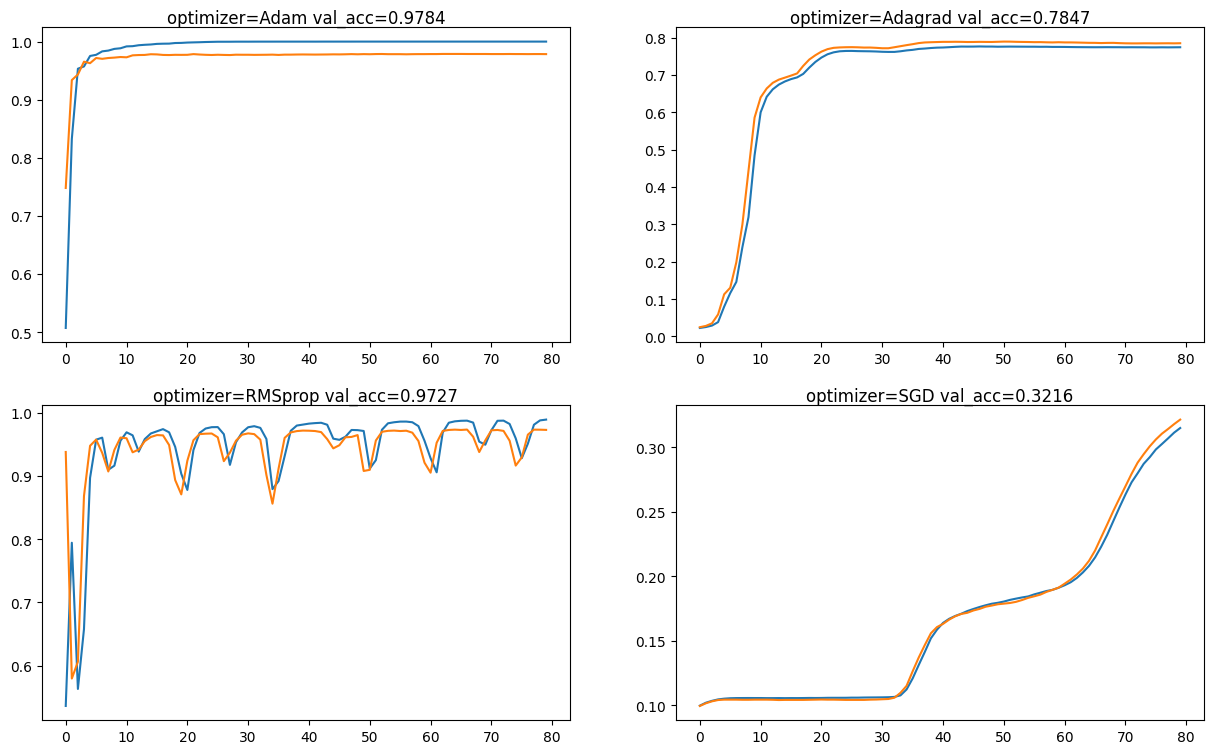

In [23]:
n_layers = 2
n_nodes = 128
epochs = 80
optimizers = [Adam, Adagrad, RMSprop, SGD]
opt_labels = ['Adam', 'Adagrad', 'RMSprop', 'SGD']

plt.figure(figsize=(15,9))
for i in tqdm(range(len(optimizers))):
    opt = optimizers[i]
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    history, test_acc = fit_model()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('optimizer='+str(opt_labels[i])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('optimizer.png', dpi=300, bbox_inches='tight')
plt.show()

We see that the Adam optimizer scores the highest, and has the smoothest trend over epochs.

# Batch Size

Now, selecting the Adam optimizer based on the results above, I will play around with the batch size. This determines how many samples will enter the gradient descent algorithm at a time. A smaller batch size can have a regularizing effect, due to a less accurate estimate of the error gradient, but extends the number of jobs to do per epoch.

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 4/4 [02:04<00:00, 31.01s/it]


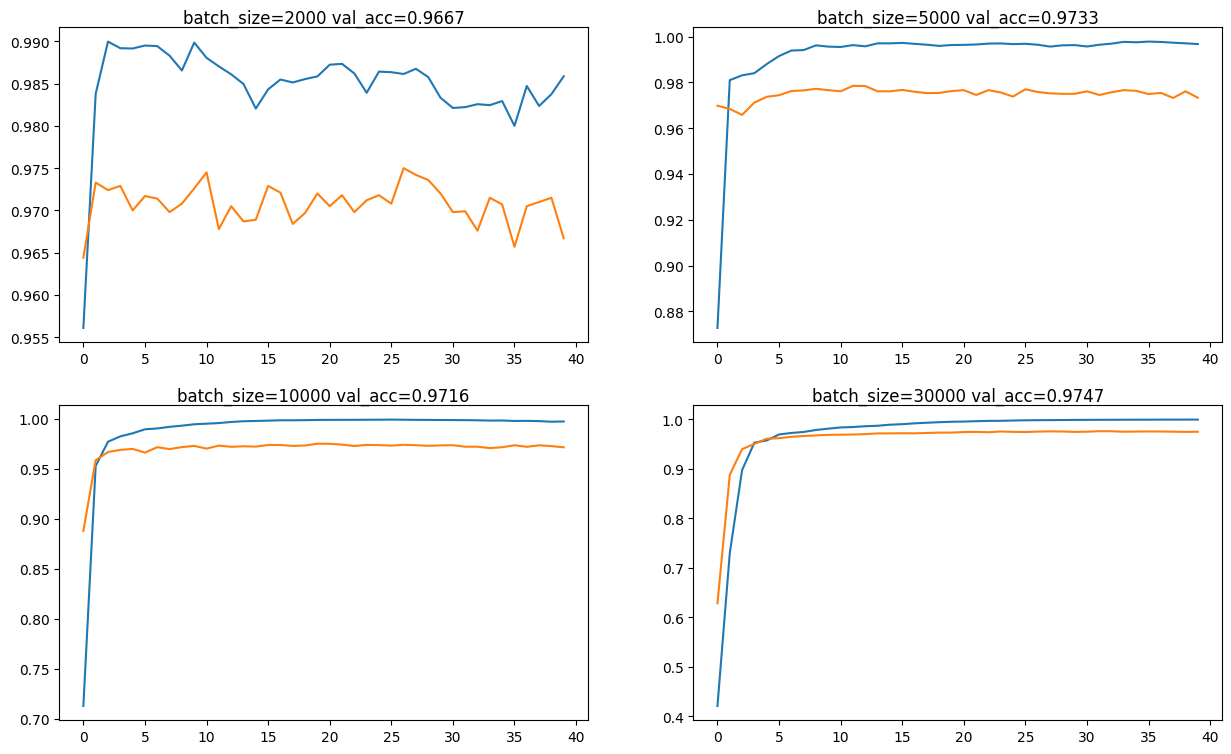

In [38]:
opt = Adam
batch_sizes = [2000,5000,10000,30000]

plt.figure(figsize=(15,9))
for i in tqdm(range(len(batch_sizes))):
    batch_size = batch_sizes[i]
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    history, test_acc = fit_model()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('batch_size='+str(batch_sizes[i])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('batch_size.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning Rate

Of the batch sizes searched, 30000 did the best, so I will select that value, and move on to searching values for learning rate. Learning rate, in addition to the gradient, defines the step size of the optimization algorithm.

$x_{new} = x_{old} - \eta \nabla C$, where $\eta$ is the learning rate, and $\nabla C$ is the gradient of the cost function.

A large learning rate allows the model to learn faster, but at the cost of arriving at a suboptimal set of weights. A small learning rate may arrive at more optimal weights, but extend the length of the training process, and/or get stuck in local optima.

100%|██████████| 4/4 [03:43<00:00, 55.93s/it]


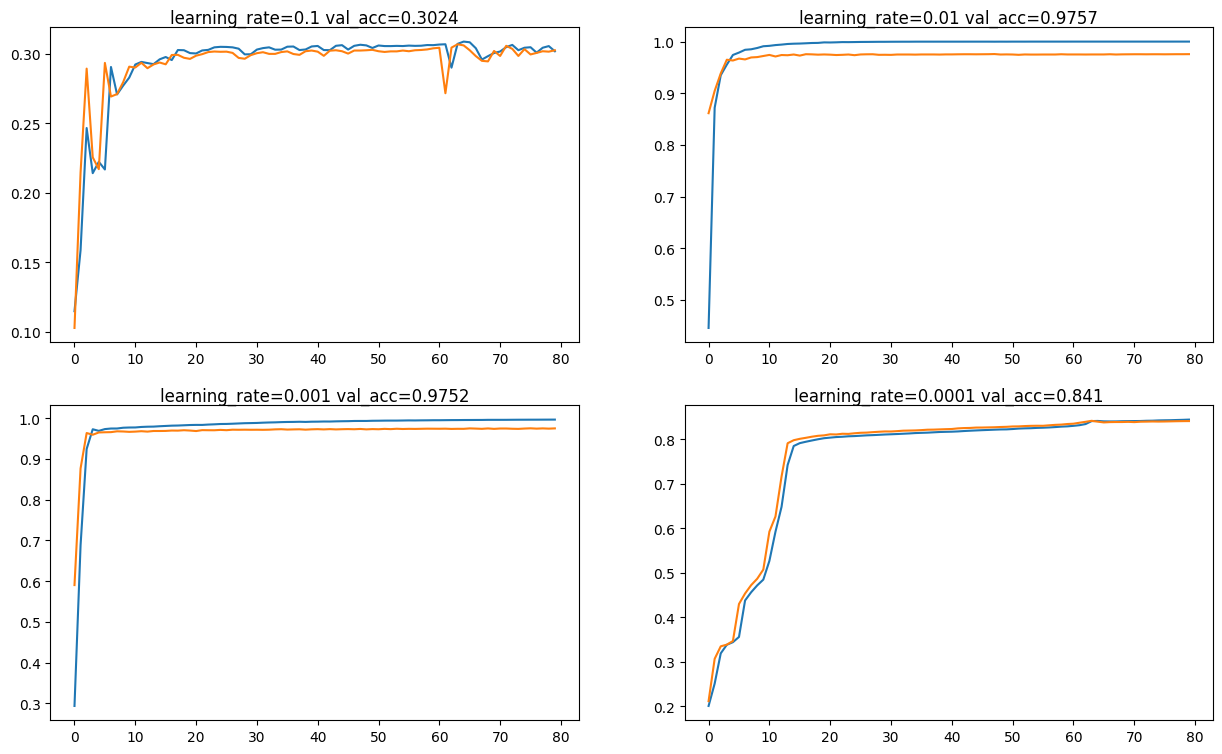

In [25]:
batch_size = 30000
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

plt.figure(figsize=(15,9))
for i in tqdm(range(len(learning_rates))):
    lr = learning_rates[i]
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    history, test_acc = fit_model()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('learning_rate='+str(learning_rates[i])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('learning_rate.png', dpi=300, bbox_inches='tight')
plt.show()

An alternative to using a fixed learning rate is to vary the learning rate over the training process. The way in which it changes over time is called decay. Optimizers that inherently vary the learning rate during training are RMSProp, Adagrad, and Adam.

## Momentum

Selecting the top performing learning rate, I will proceed to search momentum values. Momentum, like learning rate, is a parameter of the optimization algorithm, and modulates the step sizes taken during gradient descent to have inertia (continued motion) from the previous step.

<i>"Momentum is designed to accelerate learning, especially in the face of high curvature, small but consistent gradients, or noisy gradients... common values used in practice include 0.5, 0.9, and 0.99"</i>
- Deep Learning (2016)

100%|██████████| 4/4 [03:43<00:00, 55.99s/it]


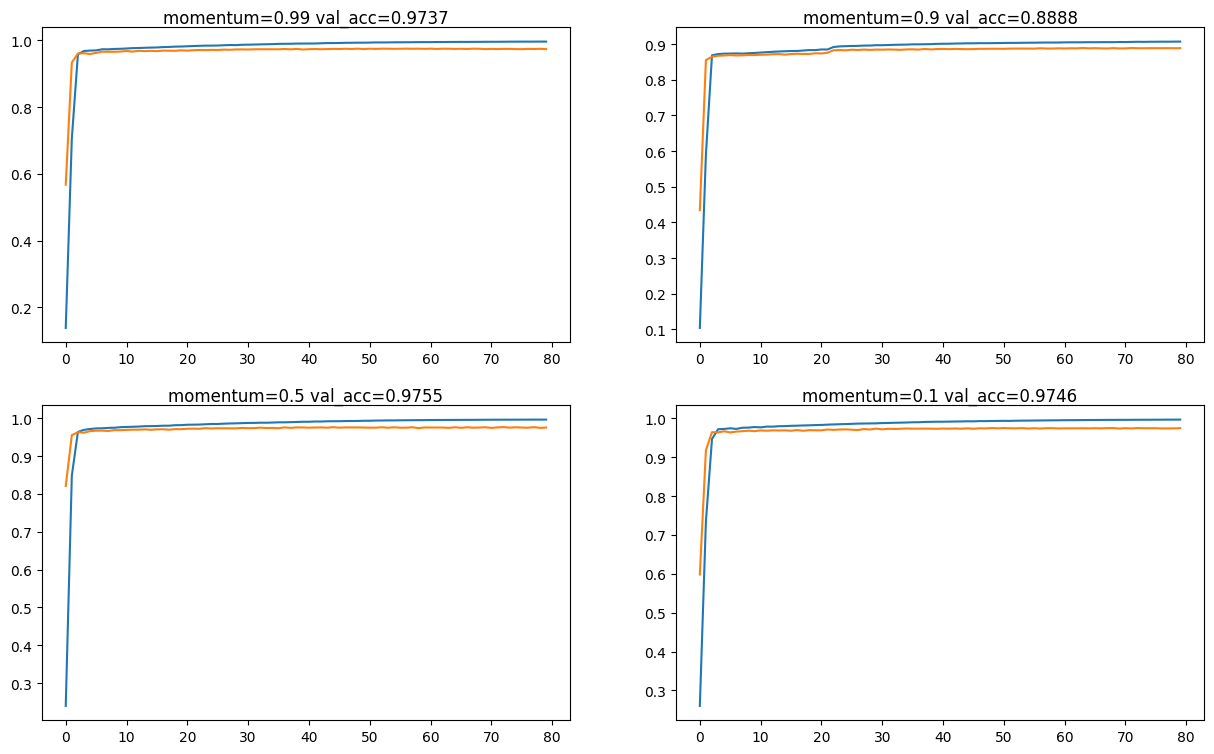

In [26]:
lr = 0.001
momentums = [0.99, 0.9, 0.5, 0.1]

plt.figure(figsize=(15,9))
for i in tqdm(range(len(momentums))):
    momentum = momentums[i]
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    history, test_acc = fit_model()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('momentum='+str(momentums[i])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('momentum.png', dpi=300, bbox_inches='tight')
plt.show()

## Weight Regularization

Weight regularization penalizes the magnitude of the weights, encouraging them to remain small. As with regression, the two main approaches are <a href="https://en.wikipedia.org/wiki/Regularization_(mathematics)#L1_and_L2_Regularization">L1 and L2 regularization</a>. L1 encourages weights to shrink to 0 if possible, whereas L2 penalizes them less severely, but also results in less sparsity.

100%|██████████| 2/2 [07:40<00:00, 230.16s/it]


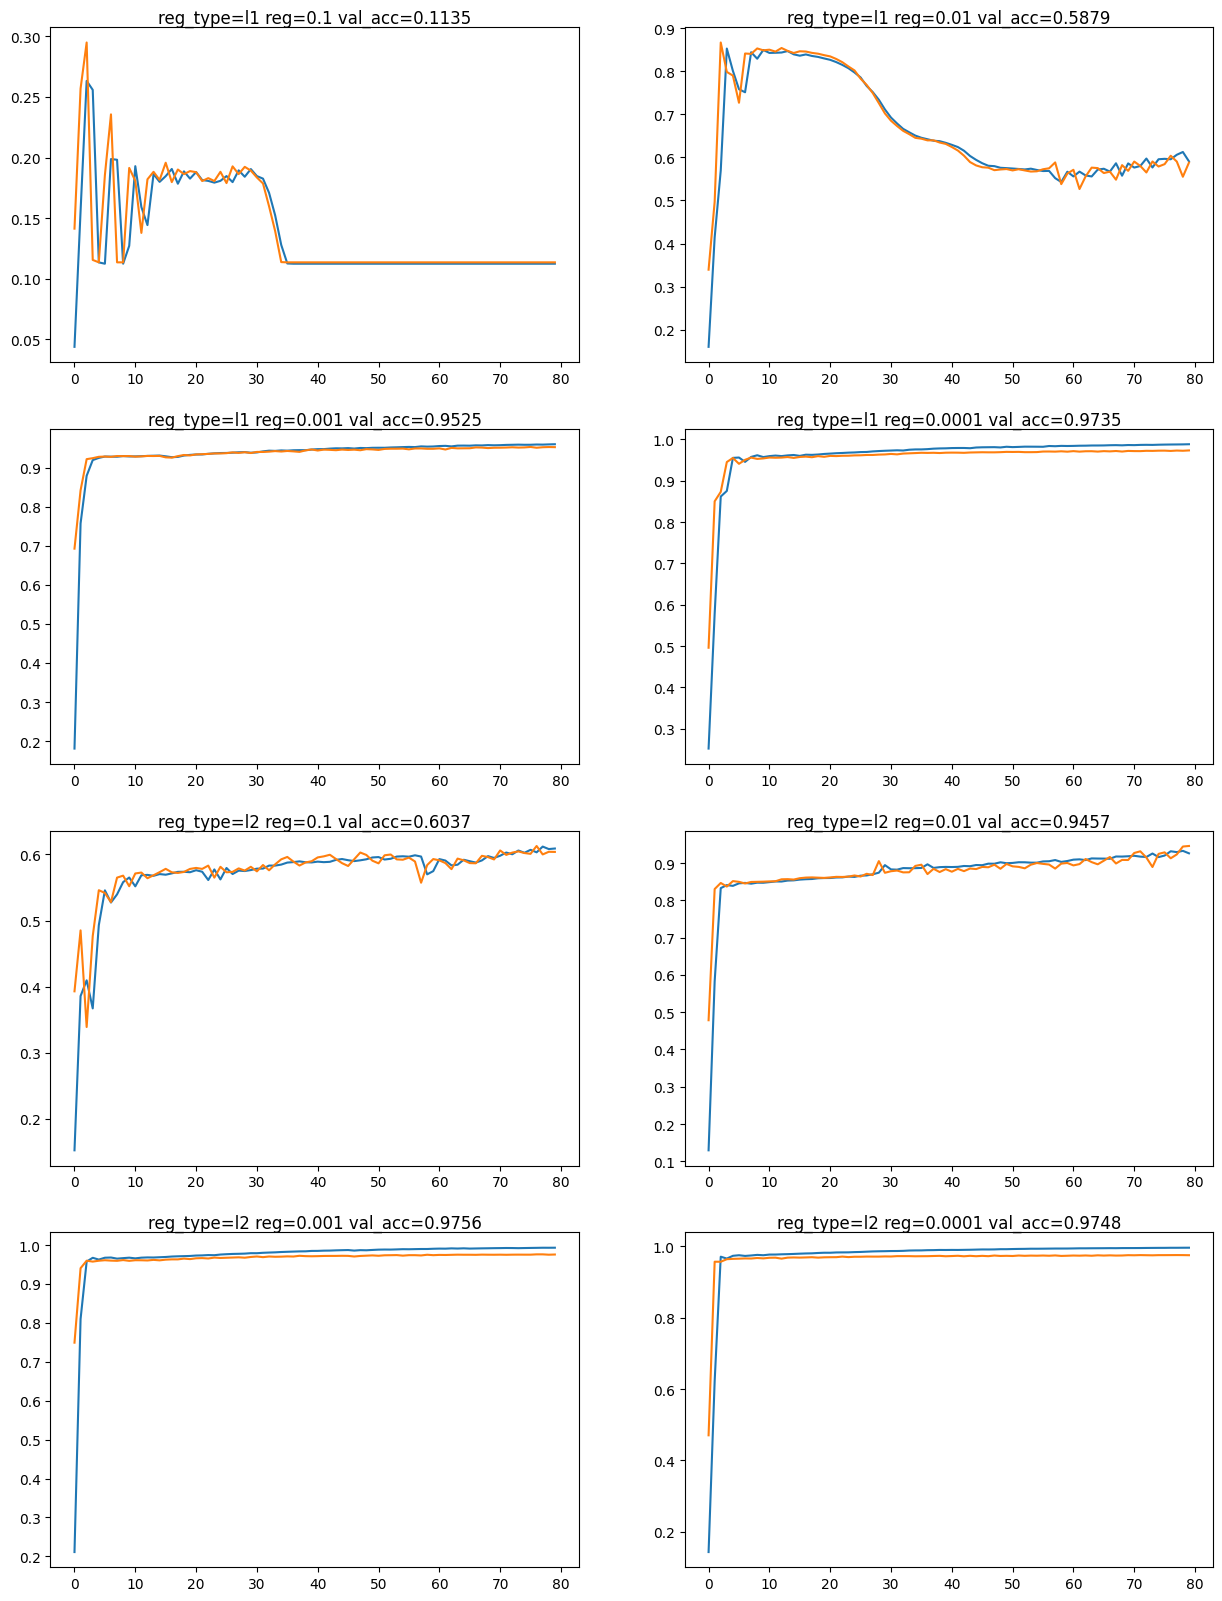

In [27]:
momentum = 0.1
reg_types = [l1, l2]
reg_type_labels = ['l1', 'l2']
regs = [1e-1, 1e-2, 1e-3, 1e-4]
counter = 0

plt.figure(figsize=(15,20))
for i in tqdm(range(len(reg_types))):
  reg_type = reg_types[i]

  for j in range(len(regs)):
      reg = regs[j]
      history, test_acc = fit_model()
      counter = counter + 1
      plot_no = 420 + counter
      plt.subplot(plot_no)
      plt.plot(history.history['accuracy'], label='train')
      plt.plot(history.history['val_accuracy'], label='test')
      plt.title('reg_type='+str(reg_type_labels[i])+' reg='+str(regs[j])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('weight_regularization.png', dpi=300, bbox_inches='tight')
plt.show()

# Dropout

Another form of regularization is to randomly drop some portion of nodes from specified layers during training. We will try 10%, 25%, 50%, and 75%.

<i>"By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections".</i>
- Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)

100%|██████████| 4/4 [03:55<00:00, 58.80s/it]


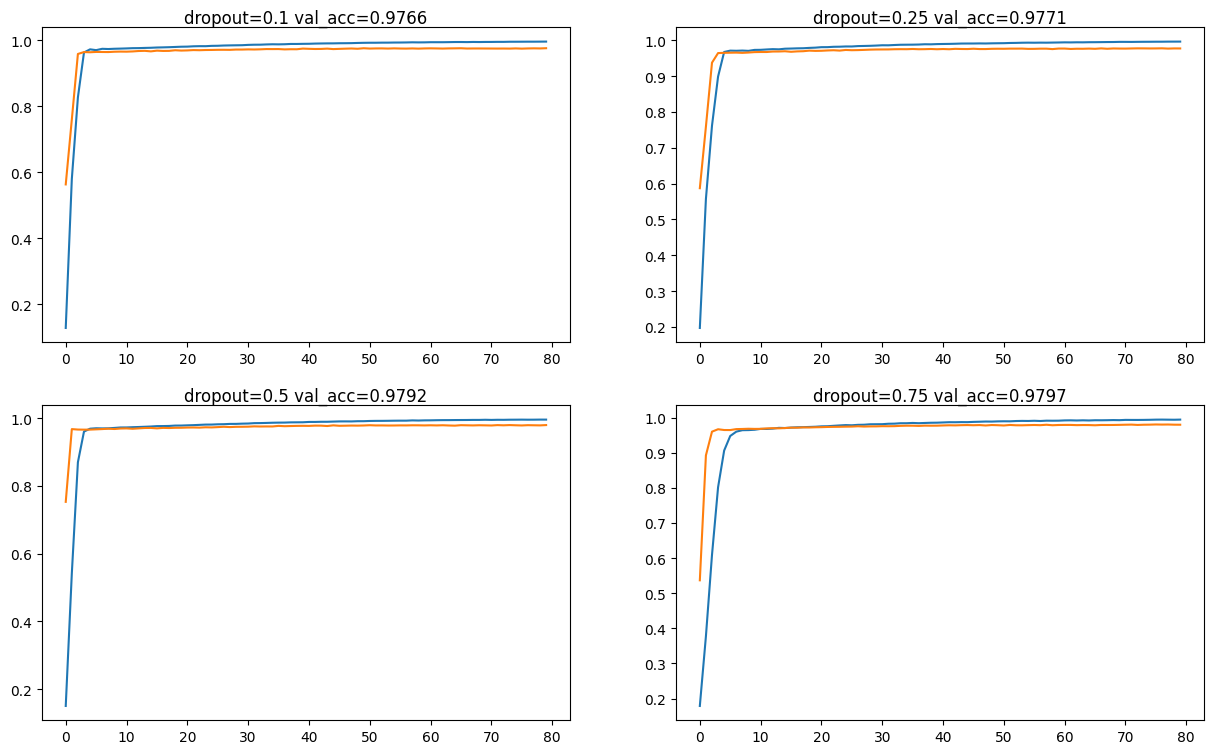

In [28]:
reg_type = l2
reg = 0.0001
dropouts = [0.1, 0.25, 0.5, 0.75]

plt.figure(figsize=(15,9))
for i in tqdm(range(len(dropouts))):
    dropout = dropouts[i]
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    history, test_acc = fit_model()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('dropout='+str(dropouts[i])+' val_acc='+str(round(test_acc,4)), pad=-50)
plt.savefig('dropout.png', dpi=300, bbox_inches='tight')
plt.show()

# Other Hyperparameters

I think you get the idea. The above can be used as a template for searching further hyperparameters, although some will require adaptation of the fitting function, such as adding special types of layers. There are several more hyperparameters that we haven't discussed yet:

## Loss Function
- Although we stuck with categorical cross-entropy above, there are other loss functions like KL divergence which could change the results if used. These two are commonly used loss functions for classification, and if working on a regression project, we could use something like mean squared error.
    
https://keras.io/api/losses/

## Activation Function
- Although above we stuck to the ReLU function as the activation function for hidden layers, there are other choices, such as the logistic function, the hyperbolic tangent (tanh) function, and for regression projects, the linear function.
    
https://keras.io/api/layers/activations/

## Early Stopping

- The longer a network trains (i.e., the greater the number of epochs), the greater the likelihood that it will overfit the training data, potentially lowering performance on the validation/test data. So why not keep tabs on the accuracy upon validation data with each epoch, and halt the training if accuracy lowers or stops improving? This is the idea of early stopping, a recommended practice.

https://keras.io/api/callbacks/early_stopping/

## Batch Normalization

- Batch normalization, implemented as a type of layer in Keras, normalizes the inputs to a layer (i.e., the output of the previous layer's activation functions). The backpropagation algorithm operates upon the transformed inputs, and error is used to update the new scale and shift parameters learned by the model.

<i>"Training deep neural networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layer change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to the change in the distributions off internal nodes of a deep network, in the course of training, as internal covariate shift."</i>
- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (2015)

<i>"BatchNorm makes the landscape of the corresponding optimization problem significantly more smooth. This ensures the gradients are more predictive and thus allows for use of a larger range of learning rates and faster network convergence."</i>
- How Does Batch Normalization Help Optimization? (2018)

https://keras.io/api/layers/normalization_layers/batch_normalization/

## Weight Constraints

Unlike weight regularization, a weight constraint checks the size or magnitude of the weights and scales them so that they are below a particular threshold. Some examples of constraints that could be used are to:
1. Force the vector norm to be 1.0
2. Limit the maximum size of the vector norm
3. Limit the minimum and maximum size of the vector norm

https://keras.io/api/layers/constraints/

## Activity Regularization

This is similar to weight regularization, however we place a penalty on the activations of the units in a neural network, encouraging their activations to be sparse. The introduction of sparsity can encourage better generalization.

https://keras.io/api/layers/regularizers/

## Noise

Adding small amounts of noise (jitter) to the training data can aid in generalization.

<i>"It is well known that the addition of noise to the input data of a neural network during training can, in some circumstances, lead to significant improvements in generalization performance. Previous work has shown that such training with noise is equivalent to a form of regularization in which an extra term is added to the error function".</i>
- Training with Noise is Equivalent to Tikhonov Regularization (2008)

https://keras.io/api/layers/regularization_layers/gaussian_noise/

# References

- Brownlee, J. (2021). Better Deep Learning (1st ed.). Machine Learning Mastery. https://machinelearningmastery.com/better-deep-learning/

- Nielsen, M. (2018). Neural Networks and Deep Learning. http://neuralnetworksanddeeplearning.com/index.html

- Sanderson, G. (2017). Neural Networks. 3Blue1Brown. https://www.3blue1brown.com/topics/neural-networks

- Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Deep Learning. MIT Press, 2016.
https://www.deeplearningbook.org/

- Cohen, M. X. (2024). A deep understanding of deep learning [Online Video]. Udemy. https://www.udemy.com/course/deeplearning_x

- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. The Journal of Machine Learning Research. https://dl.acm.org/doi/abs/10.5555/2627435.2670313

- Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Arxiv. https://doi.org/arXiv:1502.03167v3

- Santurkar, S., Tsipiras, D., Ilyas, A., & Madry, A. (2018). How Does Batch Normalization Help Optimization? Arxiv. https://doi.org/arXiv:1805.11604v5

- Bishop, C. M. (1995). Training with Noise is Equivalent to Tikhonov Regularization. Neural Computation. https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-tikhonov-nc-95.pdf

- Brownlee, J. (2021). Optimization for Machine Learning (A. Tam, Ed.) (1st ed.). MachineLearningMastery. https://machinelearningmastery.com/optimization-for-machine-learning/

- Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization. Journal of Machine Learning Research.
https://arxiv.org/abs/1212.5701

- Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. Arxiv. https://arxiv.org/abs/1212.5701

- Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. Arxiv. https://doi.org/arXiv:1412.6980

- Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization. Journal of Machine Learning Research.
https://arxiv.org/abs/1212.5701





